In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import os
import pinocchio as pin

from pymoo.core.problem import StarmapParallelization
from pymoo.algorithms.moo.age2 import AGEMOEA2
from pymoo.decomposition.asf import ASF
from pymoo.algorithms.soo.nonconvex.pso import PSO
from auto_robot_design.description.utils import draw_joint_point
from auto_robot_design.optimization.problems import SingleCriterionProblem
from auto_robot_design.optimization.optimizer import PymooOptimizer
from auto_robot_design.pinokla.calc_criterion import ActuatedMass, EffectiveInertiaCompute, MovmentSurface, NeutralPoseMass, ManipJacobian
from auto_robot_design.pinokla.criterion_agregator import CriteriaAggregator
from auto_robot_design.pinokla.default_traj import add_auxilary_points_to_trajectory, convert_x_y_to_6d_traj_xz, get_vertical_trajectory, create_simple_step_trajectory, get_workspace_trajectory
from auto_robot_design.optimization.rewards.reward_base import PositioningConstrain, PositioningErrorCalculator, RewardManager
from auto_robot_design.optimization.rewards.jacobian_and_inertia_rewards import HeavyLiftingReward, MinAccelerationCapability
from auto_robot_design.optimization.rewards.pure_jacobian_rewards import ZRRReward
from auto_robot_design.description.builder import ParametrizedBuilder, DetailedURDFCreatorFixedEE, jps_graph2pinocchio_robot, MIT_CHEETAH_PARAMS_DICT
from auto_robot_design.generator.topologies.graph_manager_2l import GraphManager2L, get_preset_by_index
from auto_robot_design.generator.topologies.bounds_preset import get_preset_by_index_with_bounds
from auto_robot_design.optimization.saver import ProblemSaver

import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import asyncio
pin.seed(1)

In [2]:
thickness = MIT_CHEETAH_PARAMS_DICT["thickness"]
actuator = MIT_CHEETAH_PARAMS_DICT["actuator"]
density = MIT_CHEETAH_PARAMS_DICT["density"]
body_density = MIT_CHEETAH_PARAMS_DICT["body_density"]


builder = ParametrizedBuilder(DetailedURDFCreatorFixedEE,
                              density={"default": density, "G": body_density},
                              thickness={"default": thickness, "EE": 0.033},
                              actuator={"default": actuator},
                              size_ground=np.array(
                                  MIT_CHEETAH_PARAMS_DICT["size_ground"]),
                              offset_ground=MIT_CHEETAH_PARAMS_DICT["offset_ground_rl"]
                              )

In [3]:
# 1) trajectories

workspace_trajectory = convert_x_y_to_6d_traj_xz(
    *get_workspace_trajectory([-0.12, -0.33], 0.09, 0.24, 30, 60))


ground_symmetric_step1 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11, -0.32], step_height=0.07, step_width=0.22, n_points=50)))

ground_symmetric_step2 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 0.025, -0.32], step_height=0.06, step_width=-2*(-0.11 + 0.025), n_points=50)))

ground_symmetric_step3 = convert_x_y_to_6d_traj_xz(*add_auxilary_points_to_trajectory(create_simple_step_trajectory(
    starting_point=[-0.11 + 2 * 0.025, -0.32], step_height=0.05, step_width=-2*(-0.11 + 2 * 0.025), n_points=50)))


central_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.32, 0.075, 0, 50)))

left_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.32, 0.065, -0.09, 50)))

right_vertical = convert_x_y_to_6d_traj_xz(
    *add_auxilary_points_to_trajectory(get_vertical_trajectory(-0.32, 0.065, 0.09, 50)))


# set up special classes for reward calculations
error_calculator = PositioningErrorCalculator(
    error_key='error', jacobian_key="Manip_Jacobian")
# soft_constrain = PositioningConstrain(
#     error_calculator=error_calculator, points=[workspace_trajectory])
soft_constrain = PositioningConstrain(error_calculator=error_calculator, points = [ground_symmetric_step1])



In [4]:
# 2) characteristics to be calculated
# criteria that either calculated without any reference to points, or calculated through the aggregation of values from all points on trajectory
dict_trajectory_criteria = {
    "MASS": NeutralPoseMass(),
}
# criteria calculated for each point on the trajectory
dict_point_criteria = {
    "Effective_Inertia": EffectiveInertiaCompute(),
    "Actuated_Mass": ActuatedMass(),
    "Manip_Jacobian": ManipJacobian(MovmentSurface.XZ)
}
# special object that calculates the criteria for a robot and a trajectory
crag = CriteriaAggregator(dict_point_criteria, dict_trajectory_criteria)

In [5]:
# set the rewards and weights for the optimization task
zrr = ZRRReward(manipulability_key='Manip_Jacobian', trajectory_key="traj_6d", error_key="error")

In [6]:
reward_manager = RewardManager(crag=crag)
reward_manager.add_trajectory(ground_symmetric_step1, 0)
reward_manager.add_reward(zrr, 0, 1)

In [7]:
1+1+1

3

In [8]:
%gui asyncio

### First step: Choose the topology for optimization

In [15]:
objects = {f'Topology_{i}': get_preset_by_index_with_bounds(i) for i in range(4)}

output = widgets.Output()
# Create the radio button widget
radio_buttons = widgets.RadioButtons(
    options=objects,
    description='Choose a topology for optimization:',
    disabled=False
)

# Define the callback function to update the plot when the selection changes
def on_selection_change(change):
    global gm
    with output:
        output.clear_output()
        gm = change['new']
        values = gm.generate_central_from_mutation_range()
        draw_joint_point(gm.get_graph(values))
        plt.show()

# Set initial value to None
radio_buttons.value = None

# Attach the callback function to the radio button widget
radio_buttons.observe(on_selection_change, names='value')

# Create proceed button
proceed_button = widgets.Button(description='Confirm choice',
                                layout=widgets.Layout(width='300px', height='50px'))  # Set width and height)

# Set initial value of the gm
gm:GraphManager2L = get_preset_by_index_with_bounds(-1)

with output:
    draw_joint_point(gm.get_graph(gm.generate_central_from_mutation_range()))
    plt.show()


def on_slider_change(change):
    with output:
        output.clear_output()
        values = gm.generate_central_from_mutation_range()
        values[0] = change['new']
        draw_joint_point(gm.get_graph(values))
        plt.show()
# Function to handle proceed button click
def proceed_to_next_stage(b):

    if radio_buttons.value is not None:
        
        radio_buttons.unobserve_all()
        clear_output(wait=True)
        first_key = list(gm.mutation_ranges.keys())[0]
        joint_name = first_key[:-2]
        values = np.linspace(gm.mutation_ranges[first_key][0],gm.mutation_ranges[first_key][1],5,endpoint=True) 
        slider = widgets.SelectionSlider(options=values, value=values[0], description='Chose the motor position:', disabled=False, continuous_update=False, orientation='horizontal', readout=True)
        slider.observe(on_slider_change, names='value')
        proceed_button.description = 'Proceed to optimization stage'

        display(slider, proceed_button, output)
    else:
        with output:
            print("Please make a selection first.")

proceed_button.on_click(proceed_to_next_stage)


def proceed_to_optimization_stage(b):
    pass


# display(HTML("""
# <style>
#     .widget-radio-box label {
#         color: blue !important;
#     }
#     /* Ensure the color stays the same when an option is selected */
#     .widget-radio-box input[type="radio"]:checked + label {
#         color: blue !important;
#     }
# </style>
# """))
display(radio_buttons, proceed_button,output)

# draw_joint_point(get_preset_by_index_with_bounds(-1).get_graph(get_preset_by_index_with_bounds(-1).generate_central_from_mutation_range()))
# plt.show()







SelectionSlider(continuous_update=False, description='Chose the motor position:', options=(-0.3000000000000000…

Button(description='Proceed to optimization stage', layout=Layout(height='50px', width='300px'), style=ButtonS…

Output(outputs=({'output_type': 'display_data', 'data': {'text/plain': '<Figure size 640x480 with 1 Axes>', 'i…

In [13]:
list(gm.mutation_ranges.keys())[0]

'Main_knee_2'

In [ ]:



# # Async function to wait for the button press
# async def wait_for_proceed():
#     while not proceed_button.disabled:  # Keep waiting until the button is clicked
#         await asyncio.sleep(0.1)

# # Now we can use `await wait_for_proceed()` to pause execution
# print("Please make a selection and press Proceed.")
# await wait_for_proceed()

# def check_for_proceed():
#     if proceed_button.disabled:
#         return True
#     return False

# # Now, this will check if the proceed button was clicked
# while not check_for_proceed():
#     # This loop won't block the UI; it just waits for proceed_button.disabled to be True
#     pass

In [40]:
# # Async function to wait for the button press
# async def wait_for_proceed():
#     proceed_button.clicked = False
#     while not proceed_button.clicked:  # Keep waiting until the button is clicked
#         await asyncio.sleep(0.01)
# await wait_for_proceed() 

CancelledError: 

In [16]:
# Create a FloatSlider
slider = widgets.FloatSlider(
    value=0.0,
    min=-10.0,
    max=10.0,
    step=0.1,
    description='Slider:',
)

# Create a FloatText widget
text_box = widgets.FloatText(
    value=0.0,
    description='Value:',
)

# Link the slider and the text box
widgets.jslink((slider, 'value'), (text_box, 'value'))

# Display the slider and text box
display(slider, text_box)

get_preset_by_index_with_bounds(-1).graph.nodes

NodeView((JointPoint(r=None, w=array([0, 1, 0]), active=True, attach_ground=True, attach_endeffector=False, name='Main_ground', instance_counter=0), JointPoint(r=None, w=array([0, 1, 0]), active=True, attach_ground=False, attach_endeffector=False, name='Main_knee', instance_counter=0), JointPoint(r=None, w=array([0, 1, 0]), active=False, attach_ground=False, attach_endeffector=True, name='Main_ee', instance_counter=0)))

In [16]:
gm.mutation_ranges 

{'Main_knee_2': (-0.30000000000000004, -0.1),
 'Main_connection_1_0': (-0.2, 0.2),
 'Main_connection_1_2': (-0.6, 0.4),
 'Main_connection_2_0': (-0.2, 0.2),
 'Main_connection_2_2': (0.3, 0.6),
 'branch_1_0': (-0.05, 0.1),
 'branch_1_2': (-0.3, -0.1)}

In [11]:

joint = gm.get_node_by_name("Ground_connection")
gm.freeze_joint(joint,[-0.1,0,0])
gm.set_mutation_ranges()
gm.mutation_ranges 


{'Main_knee_2': (-0.30000000000000004, -0.1),
 'Main_connection_2_0': (-0.2, 0.2),
 'Main_connection_2_2': (-0.3, 0.6),
 'branch_1_0': (-0.05, 0.1),
 'branch_1_2': (-0.3, -0.1)}

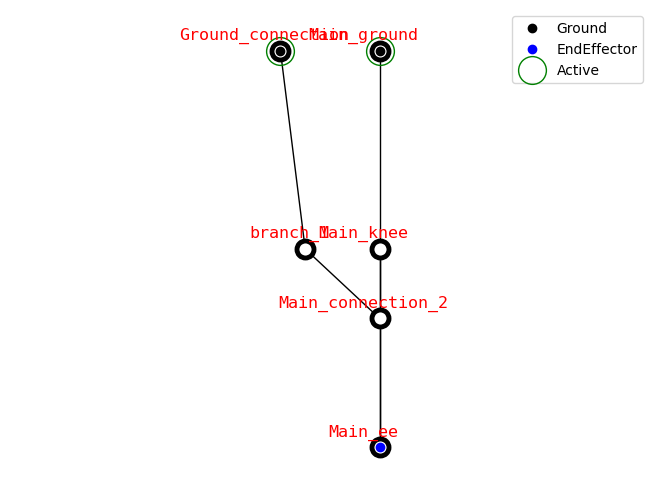

In [13]:
draw_joint_point(gm.get_graph(gm.generate_central_from_mutation_range()))

In [14]:
get_preset_by_index_with_bounds(-1).graph       

In [34]:
def run_optimization():
    N_PROCESS = 8
    pool = multiprocessing.Pool(N_PROCESS)
    runner = StarmapParallelization(pool.starmap)

    population_size = 32
    n_generations = 50

    # create the problem for the current optimization
    problem = SingleCriterionProblem(gm, builder, reward_manager,
                                  soft_constrain, 
                                  elementwise_runner=runner,
                                    Actuator=actuator)

    algorithm = PSO(pop_size=population_size, save_history=True)
    optimizer = PymooOptimizer(problem, algorithm)
    res = optimizer.run(
        False, **{
            "seed": 1,
            "termination": ("n_gen", n_generations),
            "verbose": True
        })

    best_id = np.argmin(optimizer.history["F"])
    best_x = optimizer.history["X"][best_id]
    best_reward = optimizer.history["F"][best_id]
    print("Best reward in :", -best_reward)


     1 |       32 |        - |       - |  0.9000 |  2.00000 |  2.00000 | -1.488453E+00 | -5.222900E+00
     2 |       64 |  0.29939 |       2 |  0.5922 |  2.04991 |  1.95009 | -2.259961E+00 | -5.222900E+00
     3 |       96 |  0.06321 |       3 |  0.4400 |  2.04908 |  1.96787 | -3.476930E+00 | -6.235168E+00
     4 |      128 | -3.2E-03 |       3 |  0.3980 |  2.03951 |  1.98776 | -4.656122E+00 | -7.868194E+00
     5 |      160 | -6.9E-03 |       3 |  0.3957 |  2.02528 |  1.99805 | -5.707706E+00 | -8.948957E+00
     6 |      192 | -7.0E-03 |       3 |  0.3956 |  2.01332 |  2.00891 | -6.094647E+00 | -9.061966E+00
     7 |      224 | -1.0E-02 |       3 |  0.3936 |  2.00215 |  2.02100 | -6.678183E+00 | -9.087427E+00
     8 |      256 | -1.3E-02 |       3 |  0.3916 |  1.99077 |  2.03000 | -7.426213E+00 | -9.709800E+00
     9 |      288 | -7.2E-03 |       3 |  0.3955 |  1.98094 |  2.04797 | -8.429630E+00 | -1.023072E+01
    10 |      320 | -5.9E-03 |       3 |  0.3963 |  1.96726 |  2.05607 | 